# Group-Equivariant Convolutional Neural Network Initial Experimentation on CIFAR

## Contents:<a class="anchor" id="contents"></a>
* [Setup and Data preparation](#setup)
* [Model Building and Evaluation](#buildingandeval)

## Setup and Data preparation <a class="anchor" id="setup"></a>
----------------------------------

In [1]:
%load_ext jupyternotify
import time
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
from keras import models, layers, optimizers, regularizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras import Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras
import os, shutil

<IPython.core.display.Javascript object>

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10

In [3]:
from keras_gcnn.layers import GConv2D, GBatchNorm
from keras_gcnn.layers.pooling import GroupPool

##### Importing my own custom functions from a separate notebook

In [4]:
from ipynb.fs.full.my_functions import build_and_compile_model, build_and_compile_model_GCNN, fit_model_to_generator
from ipynb.fs.full.my_functions import plot_results,plot_graphs, plot_smooth, plot_smooth_graphs, equi_check

In [3]:
# Loading in the CIFAR-10 dataset which is provided with Keras

(trainX, trainY), (testX, testY) = cifar10.load_data()
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# Converting the colour values from standard 255 RGB to floats between 0 and 1
# Changed this to be in the datagen now
# And then setting the target data as categorical

trainX /= 255.
testX /= 255.


trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# Splitting a validation set off from the train data

valX = trainX[int(np.ceil(len(trainX)*0.8)):]
trainX = trainX[:-len(valX)]
valY = trainY[int(np.ceil(len(trainY)*0.8)):]
trainY = trainY[:-len(valY)]


In [7]:
train_datagen = ImageDataGenerator()
train_datagen.fit(trainX, seed=0)

In [8]:
aug_datagen = ImageDataGenerator(rotation_range=360,
                               width_shift_range=0.2,
                               height_shift_range=0.2)
aug_datagen.fit(trainX, seed=0)

In [27]:
test_generator = train_datagen.flow(testX, testY, batch_size=32)
aug_test_generator = aug_datagen.flow(testX, testY, batch_size=32)

##### Creating a custom callback to monitor training times, based off https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

In [9]:
# Code taken and changed slightly from 
# https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
class TimeSpent(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
    def on_epoch_begin(self, epoch,logs={}):
        self.time_started = time.time()
    def on_epoch_end(self, epoch,logs={}):
        self.epoch_times.append(time.time()-self.time_started)

time_check = TimeSpent()
callbacks = [time_check]

#### Building a simple evaluation method. This was later updated and generalised for future Notebooks.

In [26]:
def model_eval(mod):
    accuracies = []
    accuracies.append(mod.evaluate_generator(test_generator,steps=1000)[1])
    accuracies.append(mod.evaluate_generator(aug_test_generator,steps=1000)[1])
    return accuracies

## Model Building and Evaluation <a class="anchor" id="buildingandeval"></a>
----------------------------------

In [5]:
modelA = build_and_compile_model(32,["maxpool","conv64","maxpool","conv64","globalmax",64])

In [29]:
modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 64)                0         
__________

In [54]:
historyA = fit_model_to_generator(modelA,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,verbose=0)
timeA = np.sum(time_check.epoch_times)
modelA.save_weights("model_saves/modelA.h5")

<Figure size 432x288 with 0 Axes>

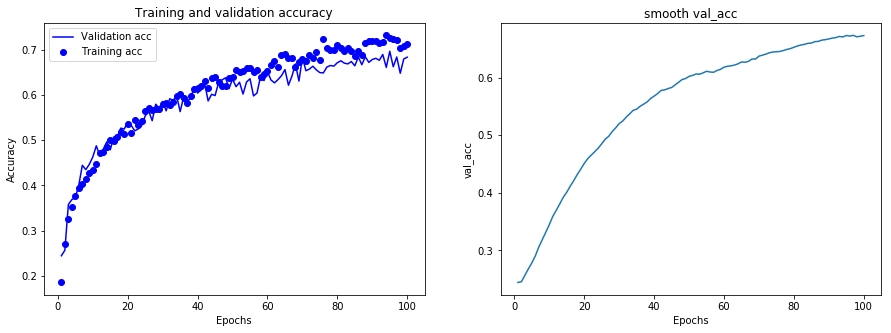

Highest val accuracy: x= 94, y= 0.6969


<Figure size 432x288 with 0 Axes>

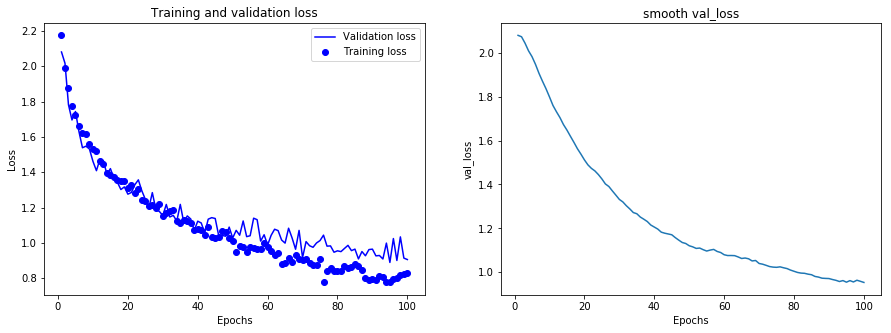

Lowest val loss: x= 94, y= 0.8895203077316284
77.95254230499268


In [55]:
plot_graphs(historyA)
print(timeA)

##### The units for each conv layer are halved to keep the parameters comparable.

In [7]:
modelA_GCNN = build_and_compile_model_GCNN("C4",16,["maxpool","conv32","maxpool","conv32","grouppool","globalmax",64])

In [30]:
modelA_GCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_7 (GConv2D)         (None, 32, 32, 64)        432       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
g_conv2d_8 (GConv2D)         (None, 16, 16, 128)       18432     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
g_conv2d_9 (GConv2D)         (None, 8, 8, 128)         36864     
_________________________________________________________________
group_pool_3 (GroupPool)     (None, 8, 8, 32)          0         
__________

In [58]:
historyA_GCNN = fit_model_to_generator(modelA_GCNN,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,verbose=0)
timeA_GCNN = np.sum(time_check.epoch_times)
modelA_GCNN.save_weights("model_saves/modelA_GCNN.h5")

<Figure size 432x288 with 0 Axes>

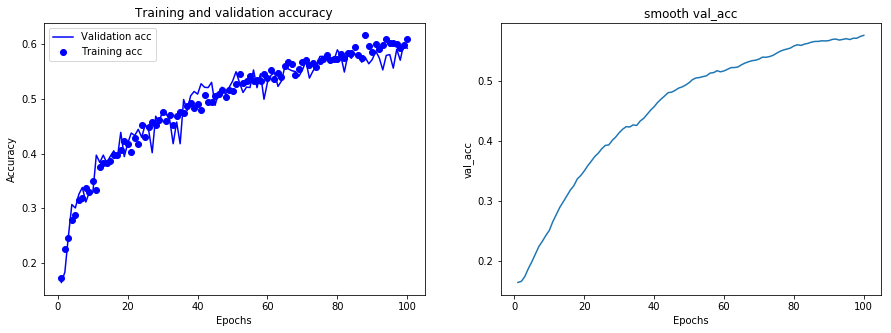

Highest val accuracy: x= 98, y= 0.6008


<Figure size 432x288 with 0 Axes>

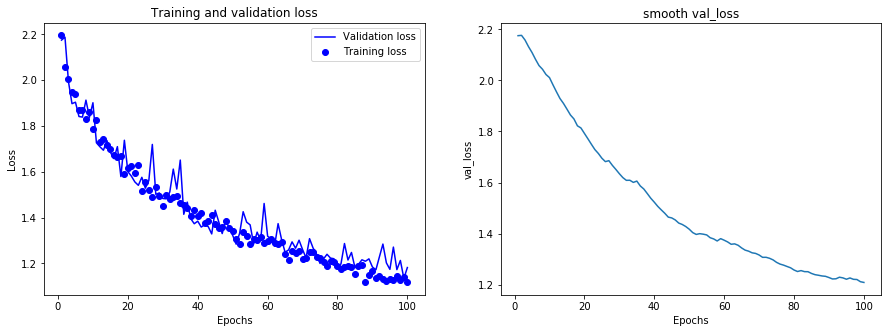

Lowest val loss: x= 98, y= 1.1343317001342774
95.30114722251892


In [59]:
plot_graphs(historyA_GCNN)
print(timeA_GCNN)

In [60]:
print(equi_check(modelA), equi_check(modelA_GCNN))

False True


In [61]:
modelA.evaluate(testX,testY)

10000/10000 [==============================] - 0s 49us/step


[0.9143546635627746, 0.6773]

In [62]:
modelA_GCNN.evaluate(testX,testY)

10000/10000 [==============================] - 1s 54us/step


[1.1885041025161742, 0.5846]

In [27]:
test_generator = train_datagen.flow(testX, testY, batch_size=32)
aug_test_generator = aug_datagen.flow(testX, testY, batch_size=32)

#### Scaling the model up

In [19]:
modelB = build_and_compile_model(64,["maxpool","dropout0.2","conv128","conv128",
                                      "maxpool","dropout0.3","conv256","maxpool",
                                      "globalmax",1024])

In [20]:
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [21]:
historyB = fit_model_to_generator(modelB,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,verbose=0)
timeB = np.sum(time_check.epoch_times)
modelB.save_weights("model_saves/modelB.h5")

<Figure size 432x288 with 0 Axes>

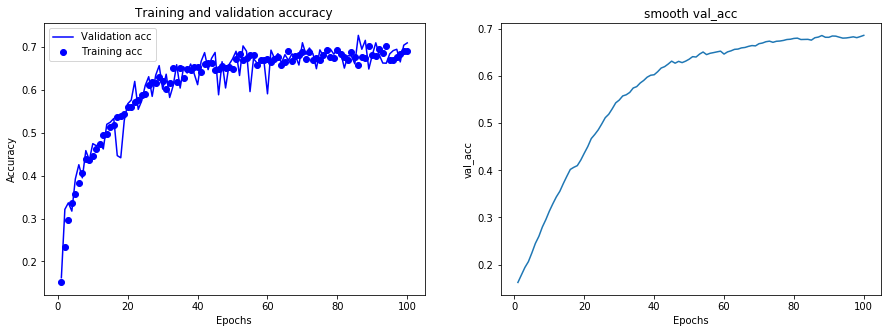

Highest val accuracy: x= 85, y= 0.7276


<Figure size 432x288 with 0 Axes>

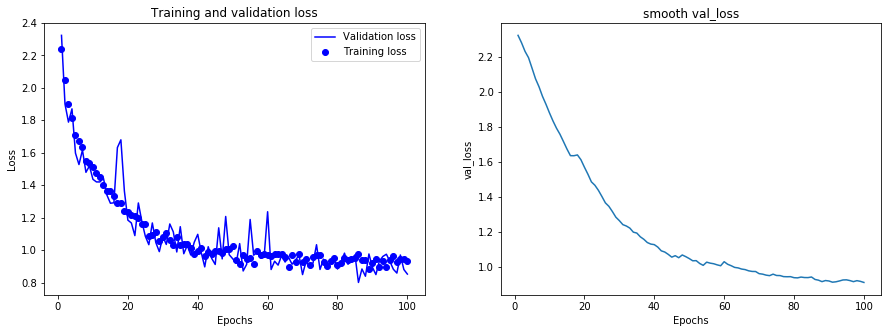

Lowest val loss: x= 85, y= 0.8007583058357238
121.47687435150146


In [22]:
plot_graphs(historyB)
print(timeB)

In [11]:
modelB_GCNN = build_and_compile_model_GCNN("C4",32,["maxpool","dropout0.2","conv64","conv64",
                                      "maxpool","dropout0.3","conv128","maxpool", "grouppool",
                                      "globalmax",1024])

In [12]:
modelB_GCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_1 (GConv2D)         (None, 32, 32, 128)       864       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
g_conv2d_2 (GConv2D)         (None, 16, 16, 256)       73728     
_________________________________________________________________
g_conv2d_3 (GConv2D)         (None, 16, 16, 256)       147456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
__________

In [13]:
historyB_GCNN = fit_model_to_generator(modelB_GCNN,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,verbose=0)
timeB_GCNN = np.sum(time_check.epoch_times)
modelB_GCNN.save_weights("model_saves/modelB_GCNN.h5")

<Figure size 432x288 with 0 Axes>

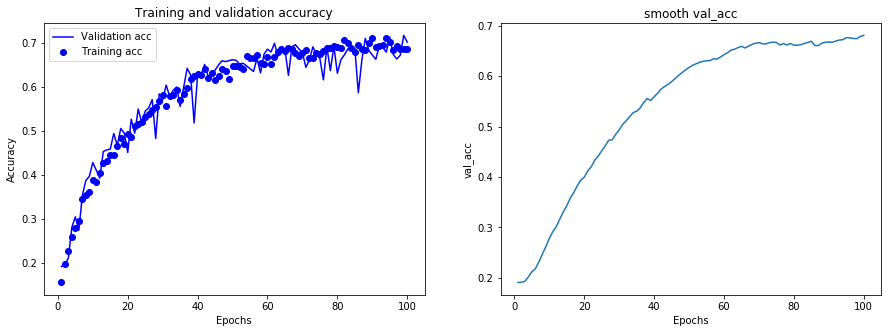

Highest val accuracy: x= 98, y= 0.7168


<Figure size 432x288 with 0 Axes>

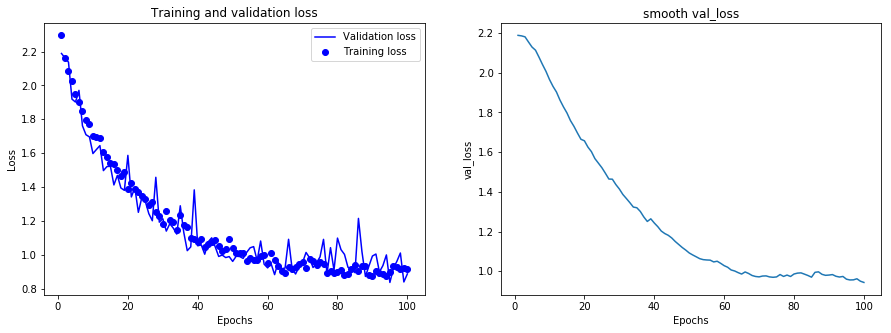

Lowest val loss: x= 94, y= 0.8368261103630066
232.78306102752686


In [14]:
plot_graphs(historyB_GCNN)
print(timeB_GCNN)

In [23]:
print(equi_check(modelB), equi_check(modelB_GCNN))

False True


In [36]:
print("modelB accuracies: ",model_eval(modelB))
print("modelB_GCNN accuracies: ", model_eval(modelB_GCNN))

modelB accuracies:  [0.7079369053580371, 0.3022971957936905]
modelB_GCNN accuracies:  [0.6938532799198798, 0.446106659989985]


#### Scaled further

In [122]:
modelC = build_and_compile_model(128,["norm","maxpool","dropout0.2","conv256","norm","conv256","norm",
                                      "maxpool","dropout0.3","conv512","norm","conv512","norm","maxpool",
                                     "conv512","norm","maxpool","globalmax",1024],learn=1e-3)

In [123]:
modelC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_50 (Batc (None, 16, 16, 256)       1024      
__________

In [124]:
historyC = fit_model_to_generator(modelC,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,verbose=0)
timeC = np.sum(time_check.epoch_times)
modelC.save_weights("model_saves/modelC.h5")

<Figure size 432x288 with 0 Axes>

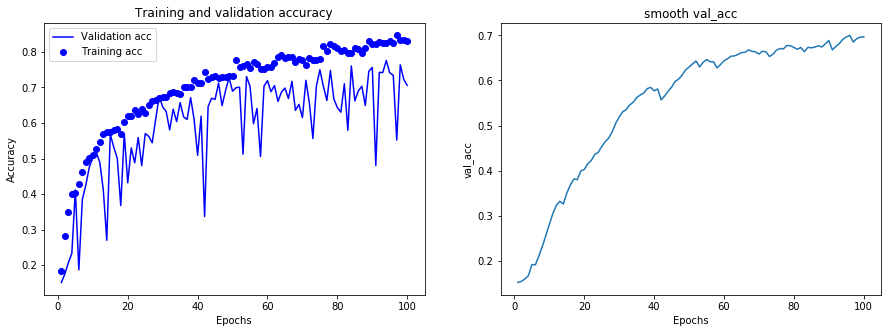

Highest val accuracy: x= 93, y= 0.7758


<Figure size 432x288 with 0 Axes>

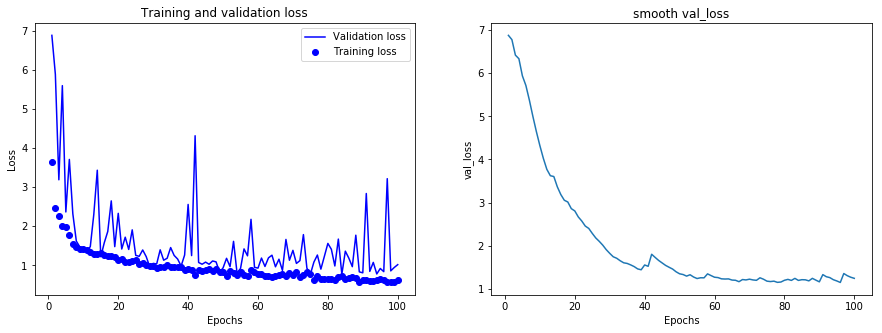

Lowest val loss: x= 83, y= 0.7703002171516419
495.3904113769531


In [125]:
plot_graphs(historyC)
print(timeC)

In [126]:
modelC_GCNN = build_and_compile_model_GCNN("C4",64,["norm","maxpool","dropout0.2","conv128","norm","conv128","norm",
                                      "maxpool","dropout0.3","conv256","norm","conv256","norm","maxpool",
                                     "conv256","norm","maxpool","grouppool","globalmax",1024],learn=1e-3)

In [127]:
modelC_GCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_32 (GConv2D)        (None, 32, 32, 256)       1728      
_________________________________________________________________
g_batch_norm_19 (GBatchNorm) (None, 32, 32, 256)       256       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 16, 16, 256)       0         
_________________________________________________________________
g_conv2d_33 (GConv2D)        (None, 16, 16, 512)       294912    
_________________________________________________________________
g_batch_norm_20 (GBatchNorm) (None, 16, 16, 512)       512       
__________

In [128]:
historyC_GCNN = fit_model_to_generator(modelC_GCNN,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,verbose=0)
timeC_GCNN = np.sum(time_check.epoch_times)
modelC_GCNN.save_weights("model_saves/modelC_GCNN.h5")

<Figure size 432x288 with 0 Axes>

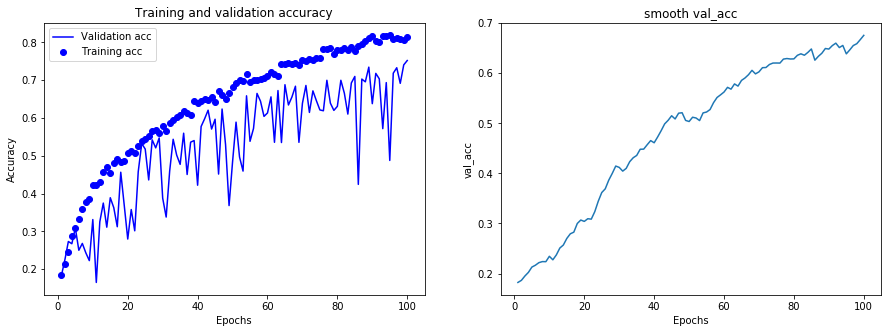

Highest val accuracy: x= 99, y= 0.7521


<Figure size 432x288 with 0 Axes>

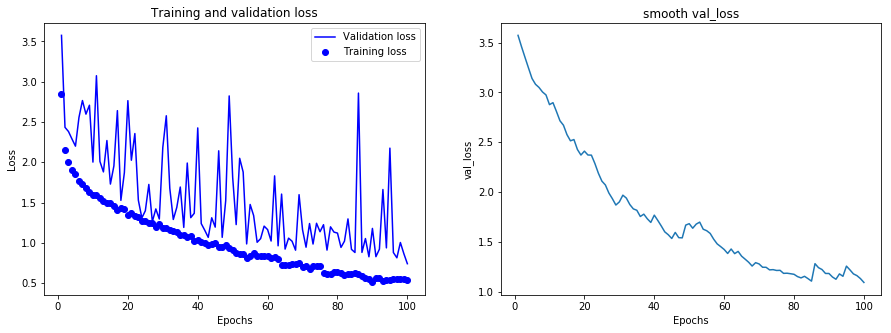

Lowest val loss: x= 99, y= 0.7414335387229919
1409.5759654045105


In [129]:
plot_graphs(historyC_GCNN)
print(timeC_GCNN)

In [134]:
print(equi_check(modelC), equi_check(modelC_GCNN))

False True


In [132]:
modelC.evaluate_generator(test_generator,steps=1000)

[1.0257952046442103, 0.7063720580871307]

In [133]:
modelC_GCNN.evaluate_generator(test_generator,steps=1000)

[0.7532245500062666, 0.7497183274912369]

In [130]:
modelC.evaluate_generator(aug_test_generator,steps=1000)

[4.179035560214406, 0.25616549824737106]

In [131]:
modelC_GCNN.evaluate_generator(aug_test_generator,steps=1000)

[1.8959182038806233, 0.46056584877315976]

### Testing Optimisers

In [82]:
modelA_GCNN_ADAM = build_and_compile_model_GCNN("C4",16,["maxpool","conv32","maxpool","conv32","grouppool","globalmax",64],opt="Adam")

In [83]:
modelA_GCNN_ADAM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_56 (GConv2D)        (None, 32, 32, 64)        432       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
g_conv2d_57 (GConv2D)        (None, 16, 16, 128)       18432     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
g_conv2d_58 (GConv2D)        (None, 8, 8, 128)         36864     
_________________________________________________________________
group_pool_14 (GroupPool)    (None, 8, 8, 32)          0         
__________

In [84]:
historyA_GCNN_ADAM = fit_model_to_generator(modelA_GCNN_ADAM,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,steps=100,verbose=0)
timeA_GCNN_ADAM = np.sum(time_check.epoch_times)
modelA_GCNN_ADAM.save_weights("model_saves/modelA_GCNN_ADAM.h5")

<Figure size 432x288 with 0 Axes>

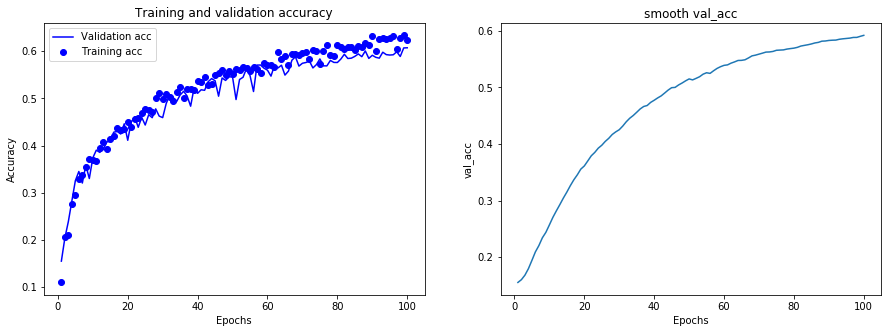

Highest val accuracy: x= 99, y= 0.6074


<Figure size 432x288 with 0 Axes>

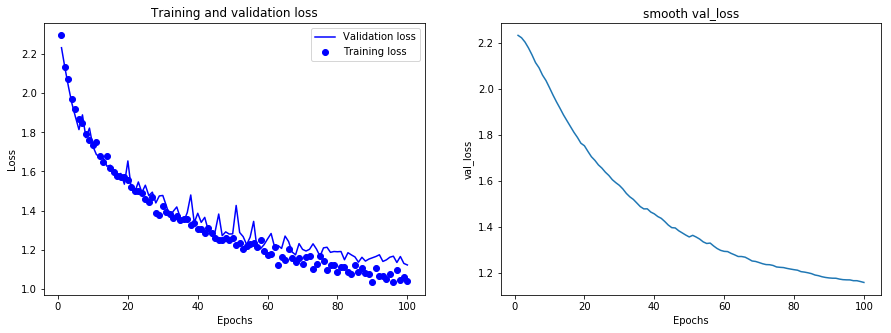

Lowest val loss: x= 99, y= 1.1225235593795777
111.96558380126953


In [85]:
plot_graphs(historyA_GCNN_ADAM)
print(timeA_GCNN_ADAM)

In [90]:
print("modelA_GCNN_ADAM accuracies: ", model_eval(modelA_GCNN_ADAM))

modelA_GCNN_ADAM accuracies:  [0.6089133700550826, 0.42751627441161744]


In [67]:
modelB_GCNN_ADAM = build_and_compile_model_GCNN("C4",32,["maxpool","dropout0.2","conv64","conv64",
                                      "maxpool","dropout0.3","conv128","maxpool", "grouppool",
                                      "globalmax",1024],opt="Adam")

In [68]:
modelB_GCNN_ADAM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_46 (GConv2D)        (None, 32, 32, 128)       864       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
g_conv2d_47 (GConv2D)        (None, 16, 16, 256)       73728     
_________________________________________________________________
g_conv2d_48 (GConv2D)        (None, 16, 16, 256)       147456    
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 8, 8, 256)         0         
__________

In [32]:
historyB_GCNN_ADAM = fit_model_to_generator(modelB_GCNN_ADAM,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,steps=100,verbose=0)
timeB_GCNN_ADAM = np.sum(time_check.epoch_times)
modelB_GCNN_ADAM.save_weights("model_saves/modelB_GCNN_ADAM.h5")

<Figure size 432x288 with 0 Axes>

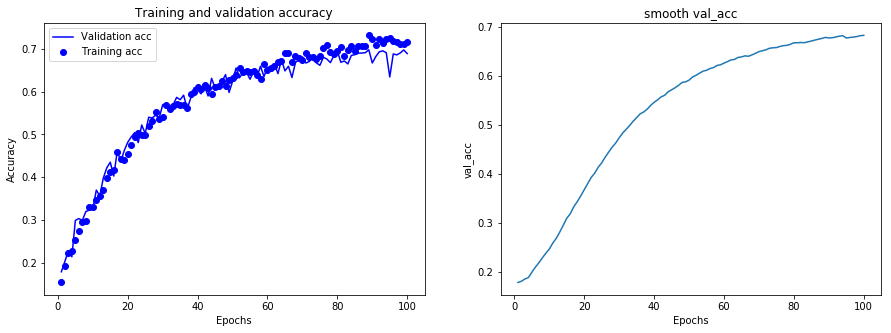

Highest val accuracy: x= 88, y= 0.6981


<Figure size 432x288 with 0 Axes>

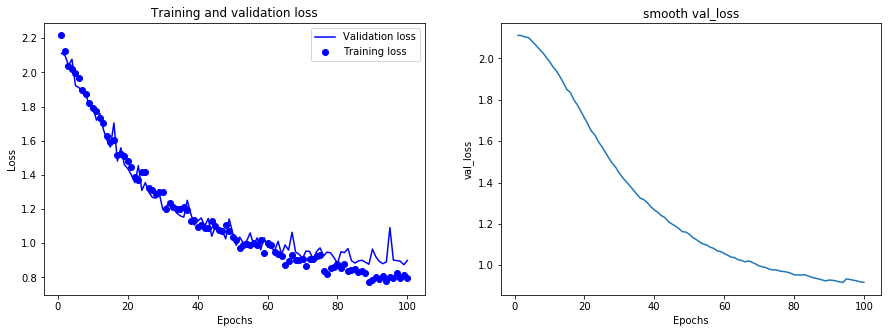

Lowest val loss: x= 98, y= 0.874372912311554
228.4790861606598


In [34]:
plot_graphs(historyB_GCNN_ADAM)
print(timeB_GCNN_ADAM)

In [35]:
print("modelB_GCNN_ADAM accuracies: ", model_eval(modelB_GCNN_ADAM))

modelB_GCNN_ADAM accuracies:  [0.6881259389083625, 0.4634138708062093]


In [52]:
modelC_GCNN_ADAM = build_and_compile_model_GCNN("C4",64,["norm","maxpool","dropout0.2","conv128","norm","conv128","norm",
                                      "maxpool","dropout0.3","conv256","norm","conv256","norm","maxpool",
                                     "conv256","norm","maxpool","grouppool","globalmax",1024],opt="Adam")

In [53]:
modelC_GCNN_ADAM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_29 (GConv2D)        (None, 32, 32, 256)       1728      
_________________________________________________________________
g_batch_norm_13 (GBatchNorm) (None, 32, 32, 256)       256       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 256)       0         
_________________________________________________________________
g_conv2d_30 (GConv2D)        (None, 16, 16, 512)       294912    
_________________________________________________________________
g_batch_norm_14 (GBatchNorm) (None, 16, 16, 512)       512       
__________

In [54]:
historyC_GCNN_ADAM = fit_model_to_generator(modelC_GCNN_ADAM,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,steps=100,verbose=0)
timeC_GCNN_ADAM = np.sum(time_check.epoch_times)
modelC_GCNN_ADAM.save_weights("model_saves/modelC_GCNN_ADAM.h5")

<Figure size 432x288 with 0 Axes>

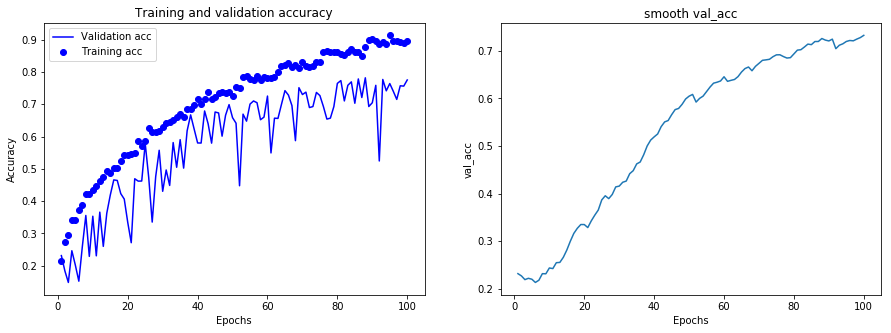

Highest val accuracy: x= 87, y= 0.782


<Figure size 432x288 with 0 Axes>

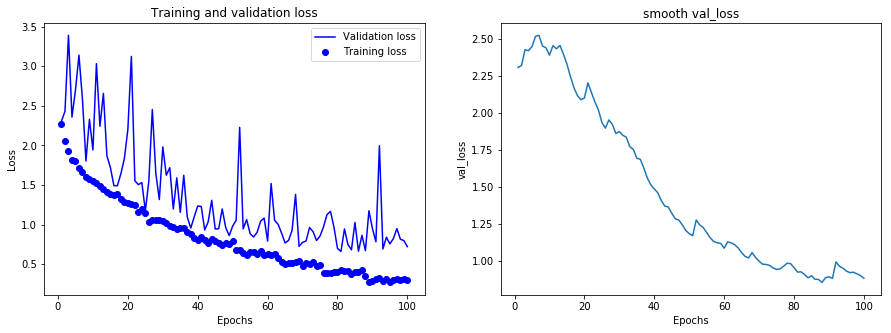

Lowest val loss: x= 80, y= 0.660015810585022
1411.618926525116


In [55]:
plot_graphs(historyC_GCNN_ADAM)
print(timeC_GCNN_ADAM)

In [56]:
print("modelC_GCNN_ADAM accuracies: ", model_eval(modelC_GCNN_ADAM))

modelC_GCNN_ADAM accuracies:  [0.7613607911867801, 0.4727090635953931]


### Dense Layer Necessity

In [95]:
modelA_GCNN_ADAM_NODENSE = build_and_compile_model_GCNN("C4",16,["maxpool","conv32","maxpool","conv32",
                                                         "grouppool","globalmax"],opt="Adam")

In [96]:
modelA_GCNN_ADAM_NODENSE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_69 (GConv2D)        (None, 32, 32, 64)        432       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
g_conv2d_70 (GConv2D)        (None, 16, 16, 128)       18432     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
g_conv2d_71 (GConv2D)        (None, 8, 8, 128)         36864     
_________________________________________________________________
group_pool_18 (GroupPool)    (None, 8, 8, 32)          0         
__________

In [97]:
historyA_GCNN_ADAM_NODENSE = fit_model_to_generator(modelA_GCNN_ADAM_NODENSE,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,steps=100,verbose=0)
timeA_GCNN_ADAM_NODENSE = np.sum(time_check.epoch_times)
modelA_GCNN_ADAM_NODENSE.save_weights("model_saves/modelA_GCNN_ADAM_NODENSE.h5")

<Figure size 432x288 with 0 Axes>

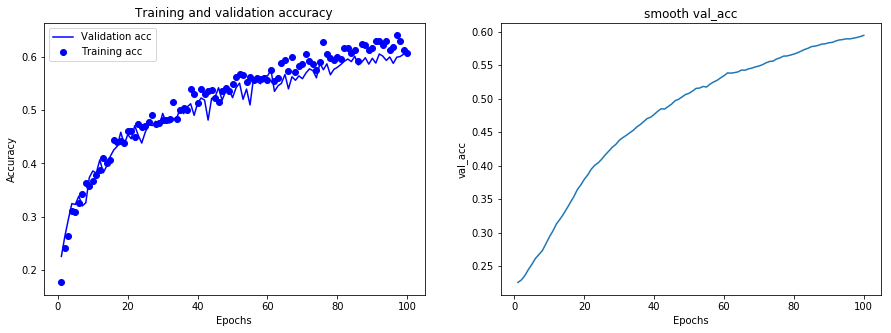

Highest val accuracy: x= 99, y= 0.6109


<Figure size 432x288 with 0 Axes>

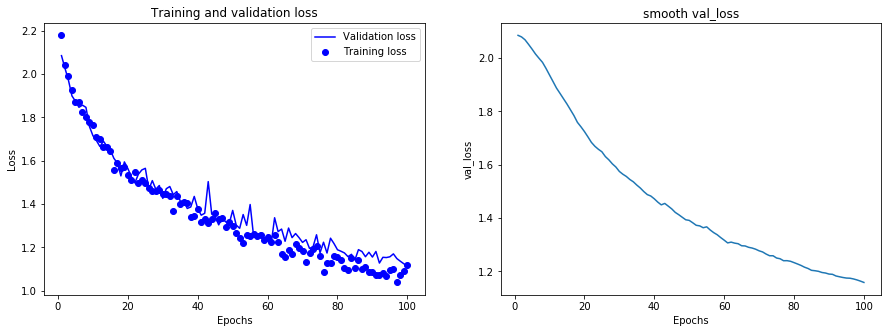

Lowest val loss: x= 99, y= 1.1134117742538452
108.37019801139832


In [98]:
plot_graphs(historyA_GCNN_ADAM_NODENSE)
print(timeA_GCNN_ADAM_NODENSE)

In [108]:
print("modelA_GCNN_ADAM_NODENSE accuracies: ", model_eval(modelA_GCNN_ADAM_NODENSE))

modelA_GCNN_ADAM_NODENSE accuracies:  [0.609257636454682, 0.4201528056112224]


In [113]:
modelB_GCNN_ADAM_NODENSE = build_and_compile_model_GCNN("C4",32,["maxpool","dropout0.2","conv64","conv64",
                                      "maxpool","dropout0.3","conv128","maxpool", "grouppool",
                                      "globalmax"],opt="Adam")

In [114]:
modelB_GCNN_ADAM_NODENSE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_80 (GConv2D)        (None, 32, 32, 128)       864       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
g_conv2d_81 (GConv2D)        (None, 16, 16, 256)       73728     
_________________________________________________________________
g_conv2d_82 (GConv2D)        (None, 16, 16, 256)       147456    
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 8, 8, 256)         0         
__________

In [115]:
historyB_GCNN_ADAM_NODENSE = fit_model_to_generator(modelB_GCNN_ADAM_NODENSE,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,steps=100,verbose=0)
timeB_GCNN_ADAM_NODENSE = np.sum(time_check.epoch_times)
modelB_GCNN_ADAM_NODENSE.save_weights("model_saves/modelB_GCNN_ADAM_NODENSE.h5")

<Figure size 432x288 with 0 Axes>

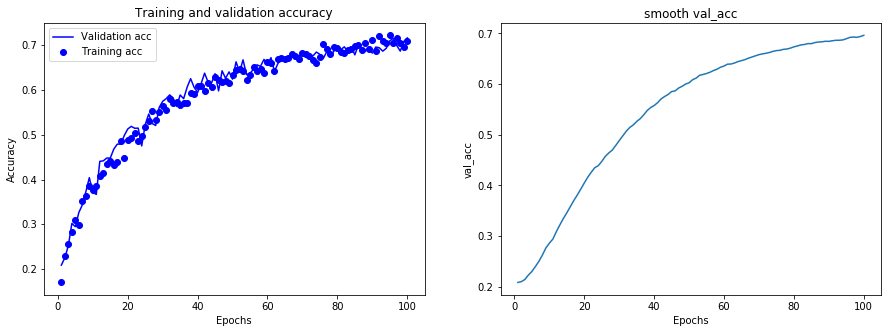

Highest val accuracy: x= 99, y= 0.7165


<Figure size 432x288 with 0 Axes>

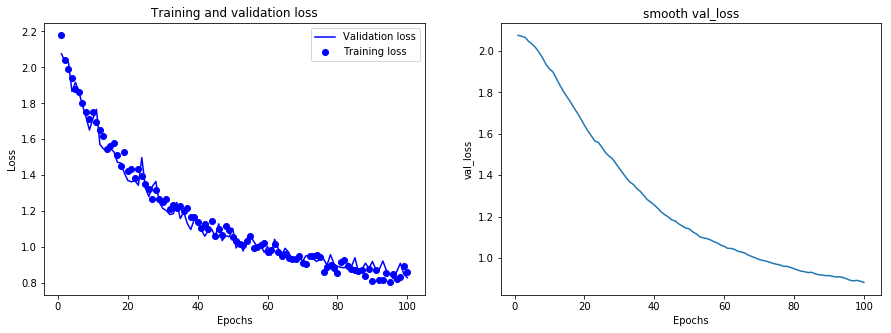

Lowest val loss: x= 95, y= 0.8238535742759705
244.9494650363922


In [116]:
plot_graphs(historyB_GCNN_ADAM_NODENSE)
print(timeB_GCNN_ADAM_NODENSE)

In [117]:
print("modelB_GCNN_ADAM_NODENSE accuracies: ", model_eval(modelB_GCNN_ADAM_NODENSE))

modelB_GCNN_ADAM_NODENSE accuracies:  [0.7093562124248497, 0.4762769153730596]


In [134]:
modelC_GCNN_ADAM_NODENSE = build_and_compile_model_GCNN("C4",64,["norm","maxpool","dropout0.2","conv128","norm","conv128","norm",
                                      "maxpool","dropout0.3","conv256","norm","conv256","norm","maxpool",
                                     "conv256","norm","maxpool","grouppool","globalmax"],opt="Adam")

In [135]:
modelC_GCNN_ADAM_NODENSE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
g_conv2d_102 (GConv2D)       (None, 32, 32, 256)       1728      
_________________________________________________________________
g_batch_norm_37 (GBatchNorm) (None, 32, 32, 256)       256       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 16, 16, 256)       0         
_________________________________________________________________
g_conv2d_103 (GConv2D)       (None, 16, 16, 512)       294912    
_________________________________________________________________
g_batch_norm_38 (GBatchNorm) (None, 16, 16, 512)       512       
__________

In [136]:
historyC_GCNN_ADAM_NODENSE = fit_model_to_generator(modelC_GCNN_ADAM_NODENSE,train_datagen,trainX,trainY,valX,valY,callbacks,epochs=100,steps=100,verbose=0)
timeC_GCNN_ADAM_NODENSE = np.sum(time_check.epoch_times)
modelC_GCNN_ADAM_NODENSE.save_weights("model_saves/modelC_GCNN_ADAM_NODENSE.h5")

<Figure size 432x288 with 0 Axes>

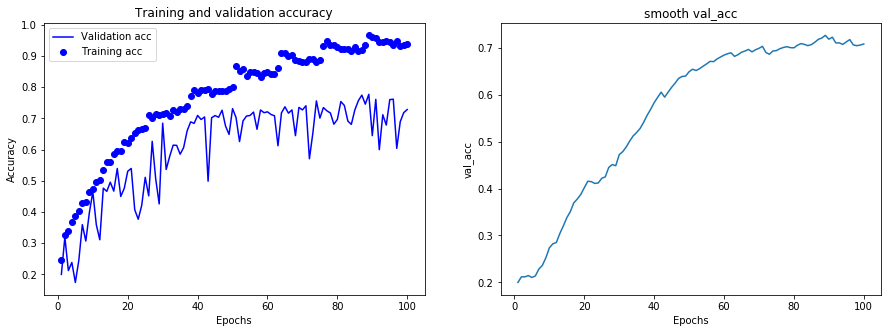

Highest val accuracy: x= 88, y= 0.7774


<Figure size 432x288 with 0 Axes>

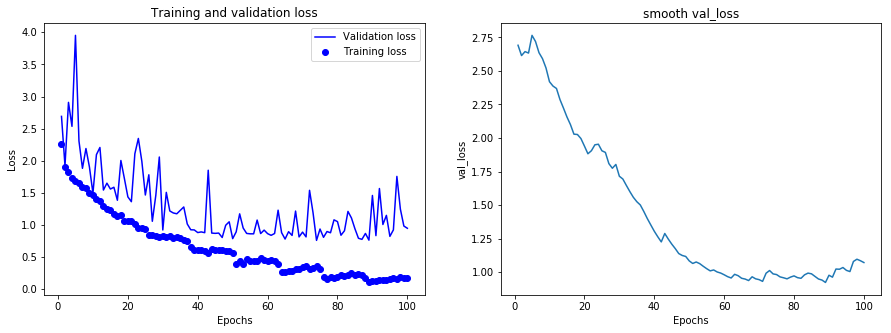

Lowest val loss: x= 73, y= 0.7608530263423919
1454.81401181221


In [137]:
plot_graphs(historyC_GCNN_ADAM_NODENSE)
print(timeC_GCNN_ADAM_NODENSE)

In [160]:
print("modelC_GCNN_ADAM_NODENSE accuracies: ", model_eval(modelC_GCNN_ADAM_NODENSE))

modelC_GCNN_ADAM_NODENSE accuracies:  [0.7556271907861792, 0.4748559619238477]
